# Week 2: Optimal Bayesian Design with Mutual Information and Linear Regression

In [123]:
import autograd.numpy as np
from autograd import grad
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, integrate, optimize
from tqdm.notebook import tqdm, trange

In [100]:
# assumption
noise = 0.2

def optimal_design(U, p_theta, p_y):
    pass

def mutual_information(d, joint, log_p_theta_yd, log_p_theta):
    def inner(theta, y, d):
        # TODO: find out if -log_p_theta or -log_p_theta^2
        return joint(theta, y, d) * (log_p_theta_yd(theta, y, d) - log_p_theta(theta))
    return integrate.dblquad(lambda y, theta: inner(theta, y, d), -5, 5, lambda _: -5, lambda _: 5)[0]

def p_theta(theta, prior_cov=np.array([[0.5]])):
    return stats.multivariate_normal.pdf(theta, mean=0, cov=prior_cov)
def log_p_theta(theta, prior_cov=np.array([[0.5]])):
    return stats.multivariate_normal.logpdf(theta, mean=0, cov=prior_cov)

# From week 1
def get_theta(X, y, covariance_prior):
    y = np.array([[y]])
    var_y = noise * np.eye(1)
    mean_theta = covariance_prior @ X.T @ np.linalg.inv(var_y + X @ covariance_prior @ X.T) @ y
    cov_theta = covariance_prior - covariance_prior @ X.T @ np.linalg.inv(var_y + X @ covariance_prior @ X.T) @ X @ covariance_prior
    return mean_theta, cov_theta

def log_p_theta_yd(theta, y, d):
    mean, cov = get_theta(d, y, np.array([[0.5]]))
    return stats.multivariate_normal.logpdf(theta, mean=mean, cov=cov)

def joint(theta, y, d):
    # Joint probability conditioned on theta with p(theta|d) = p(theta) = likelihood * prior
    def likelihood(y, d, theta):
        return stats.multivariate_normal.pdf(y, mean=theta * d, cov=np.array([[noise]]))
    return likelihood(y, d, theta) * p_theta(theta)

In [101]:
mutual_information(np.array([[1]]), joint, log_p_theta_yd, log_p_theta)

0.6263814528876483

In [ ]:
ys = []
for x in tqdm(np.linspace(-7,7,num=30)):
    ys.append(mutual_information(np.array([[x]]), joint, log_p_theta_yd, log_p_theta))

plt.plot(np.linspace(-7,7,num=30), ys)

In [103]:
# NEW THINGS
def mut_2(d, covariance_prior):
    var_y = noise * np.eye(len(d))
    cov_posterior = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    val = 0.5 * np.log(np.linalg.det(2*np.pi*np.e*cov_posterior)) - 0.5 * np.log(np.linalg.det(2*np.pi*np.e*covariance_prior))
    return val


In [176]:
prior = np.array([[7.9, 3], [4, 5]])
def f(x):
    return -mut_2(np.array([x]), prior)
def get_optimal_design(start):
    steps = optimize.minimize(f, start, method="BFGS", jac=grad(f), options={ "return_all": True })
    return steps
print(steps)

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 1.4782752471502724e-122
        x: [ 8.645e-123  1.199e-122]
      nit: 400
      jac: [ 5.848e-01  8.112e-01]
 hess_inv: [[ 1.812e-122 -5.888e-123]
            [-5.888e-123  7.318e-122]]
     nfev: 811
     njev: 811
  allvecs: [array([ 2.069e+00,  3.931e+00]), array([-2.164e-01,  2.272e-01]), array([-2.286e-01,  1.323e-01]), array([-1.093e-01,  3.779e-02]), array([-7.257e-03, -1.430e-02]), array([ 1.674e-04, -9.264e-04]), array([-1.458e-05, -7.801e-06]), array([-9.298e-06,  2.976e-06]), array([-1.545e-06,  3.706e-06]), array([ 9.892e-07,  1.862e-06]), array([ 1.022e-06,  1.467e-07]), array([ 4.013e-07, -3.483e-07]), array([-1.477e-08, -2.624e-07]), array([-1.071e-07, -8.146e-08]), array([-6.491e-08,  1.678e-08]), array([-1.478e-08,  3.081e-08]), array([ 7.425e-09,  1.540e-08]), array([ 8.423e-09,  2.122e-09]), array([ 3.480e-09, -2.622e-09]), array([ 1.051e-10, -2.207e-09]), array([-8.

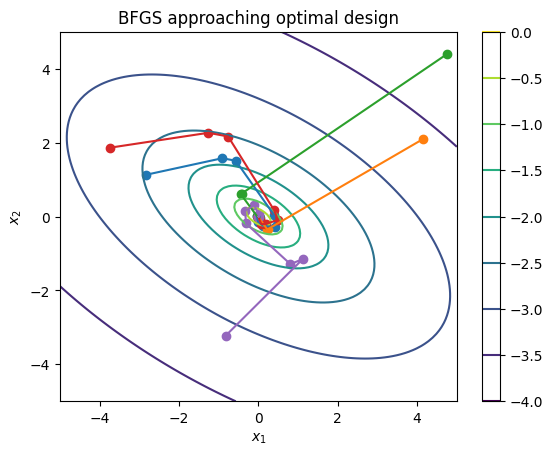

In [183]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

Z = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        d = np.array([[x[i], y[j]]]).T
        Z[i][j] = mut_2(d.T, prior)

# Make the contour plot
fig, ax = plt.subplots()
contour = ax.contour(X, Y, Z)
for start in np.random.random((5,2)) * 10 - np.ones((5,2))*5:
    steps = get_optimal_design(start)
    ax.scatter(np.array(steps.allvecs)[:,0], np.array(steps.allvecs)[:,1])
    #for i in range(0, len(steps.allvecs), 2):
        #next_step = i + 1
        #if (i == len(steps.allvecs)):
        #    next_step = i
        #ax.arrow(steps.allvecs[i][0],steps.allvecs[i][1], steps.allvecs[next_step][0] - steps.allvecs[i][0], steps.allvecs[next_step][1] - steps.allvecs[i][1])
    ax.plot(np.array(steps.allvecs)[:,0], np.array(steps.allvecs)[:,1])
# Add a colorbar
cbar = fig.colorbar(contour)

# Add some labels and a title
ax.set_title('BFGS approaching optimal design')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# Show the plot
plt.show()